Load modules and define unitlity functions.

In [2]:
import numpy as np
import cv2
import scipy
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20, 15)

img_dir = "images/"

def show_pics(plot_colum_size, plot_row_size, imgs, **kargs):
    for i in range(plot_colum_size * plot_row_size):
        plt.subplot(plot_row_size,plot_colum_size,i+1)
        img = imgs[i]
        d = len(img.shape)
        if d != 3:
            kargs['cmap'] = 'gray'
        plt.imshow(img, **kargs)
    plt.show()

def resize_greatest_ax(img, s):
    y, x = img.shape[:2]
    if x > y:
        r = s / x
        nx = s
        ny = y * r
    else:
        r = s / y
        nx = x * r
        ny = s
    return cv2.resize(img, (int(nx), int(ny)))

def feature_match(img, resize=True):
    gray = img#cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    if resize:
        gray = resize_greatest_ax(gray, 512)

#     descriptor = cv2.ORB_create(400)
#     descriptor = cv2.xfeatures2d.SIFT_create(400)
    descriptor = cv2.xfeatures2d.SURF_create(400)
    (kps, features) = descriptor.detectAndCompute(gray, None)
    return gray, kps, features

def align_images(l, r, resize=True):

    # for _ in range(100):
    lg, lkps, lf = feature_match(l, resize)
    rg, rkps, rf = feature_match(r, resize)
    bf = cv2.DescriptorMatcher_create("BruteForce")
    matches = bf.knnMatch(rf, lf, k=2)
    good = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good.append(m)
    matches = good
    
    MIN_MATCH_COUNT = 10
    if len(matches)>MIN_MATCH_COUNT:
        lpts = np.float32([ lkps[m.trainIdx].pt for m in matches ]).reshape(-1, 1, 2)
        rpts = np.float32([ rkps[m.queryIdx].pt for m in matches ]).reshape(-1, 1, 2)
        H, mask = cv2.findHomography(rpts, lpts, cv2.RANSAC, 5.0)
        matchesMask = mask.ravel().tolist()
    else:
        print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
        matchesMask = None
        
    result = cv2.warpPerspective(rg, H,
        (lg.shape[1] + rg.shape[1], rg.shape[0]))
    A = lg.copy()
    B = result[:,lg.shape[1]:]
    return A, B, result, H

In [3]:
%%time
prefix = "r"
l = cv2.imread(img_dir + prefix + "l.jpg")
r = cv2.imread(img_dir + prefix + "r.jpg")

Wall time: 547 ms


0


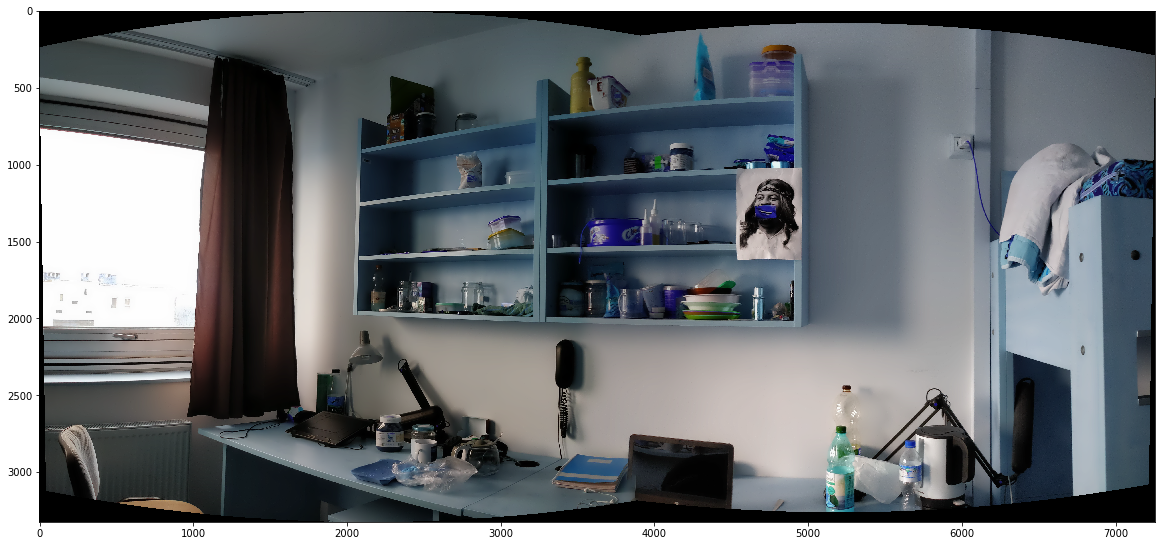

In [3]:
stitcher = cv2.createStitcher(False)
res, pano = stitcher.stitch([l, r])
print(res)
show_pics(1, 1, [pano])

In [4]:
A, B, r_wr, H = align_images(l, r)

In [5]:
%%time
h, w, c = A.shape
corner_points = np.array([[0,0,1],
                          [0,h,1],
                          [w,h,1],
                          [w,0,1]
                         ])
t_c = H.dot(corner_points.T)
cs = np.array([[int(c[0]/c[2]), int(c[1]/c[2])] for c in t_c.T])
mask = np.zeros((h, 2*w), A.dtype)
mask = cv2.fillPoly(mask, [cs], (255,255,255))

Wall time: 201 ms


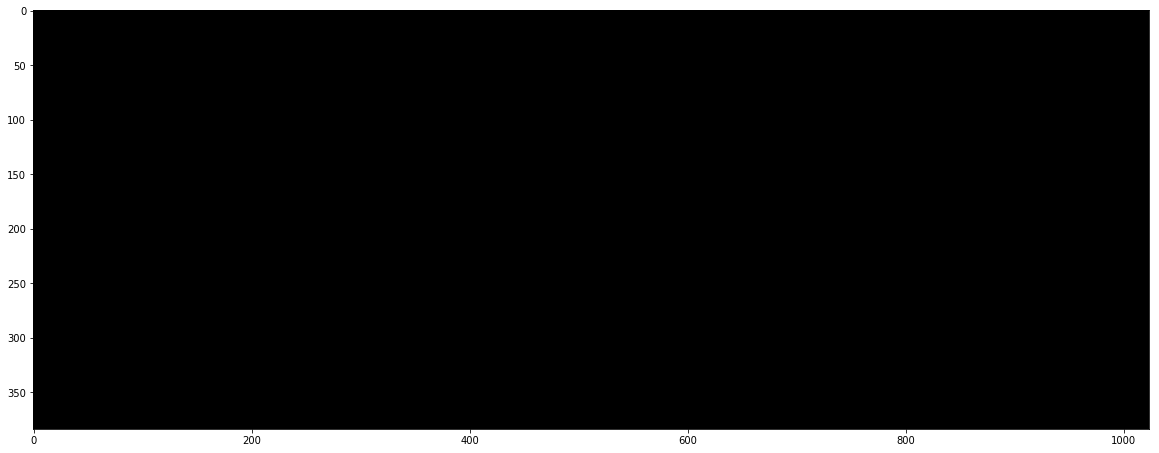

In [57]:
mask = 255 * np.ones(mask.shape, mask.dtype)
show_pics(1, 1, [mask])

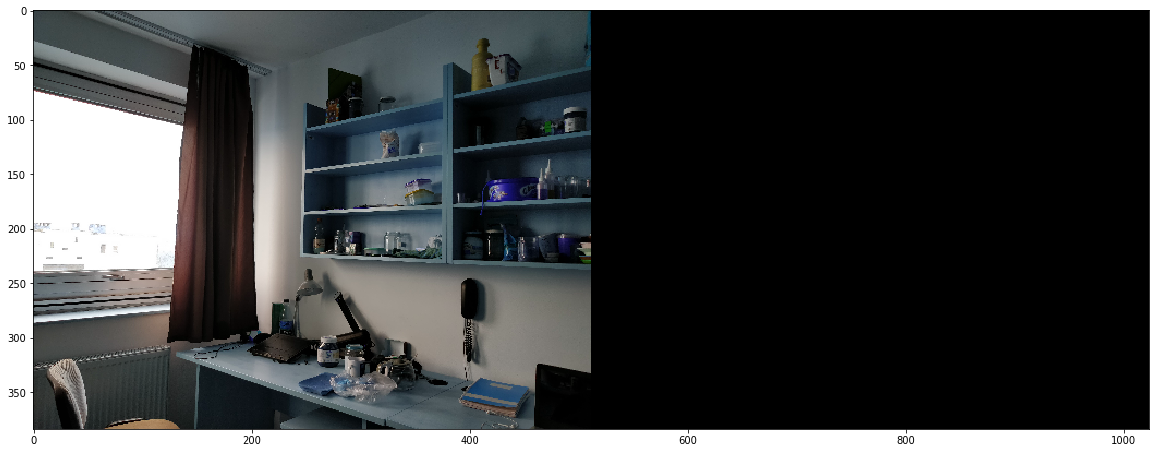

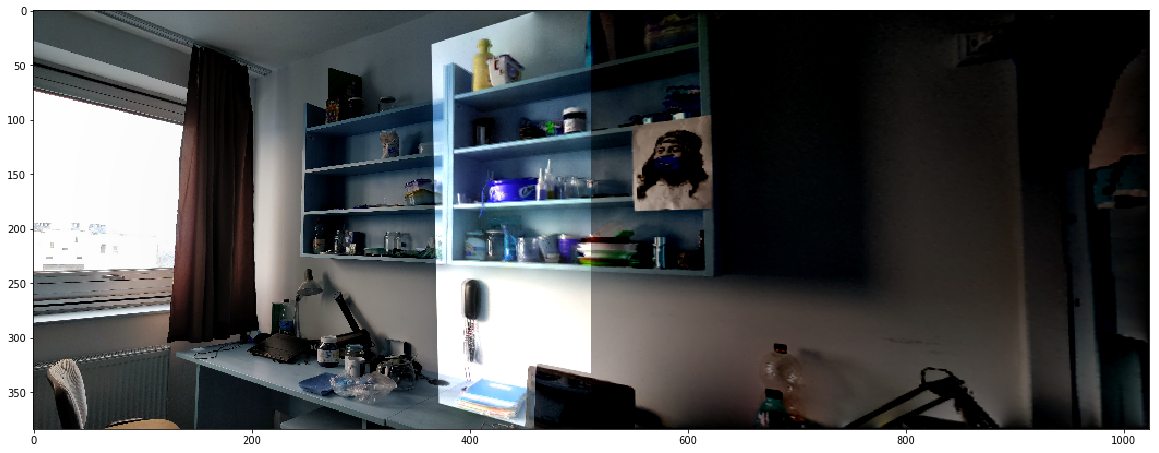

In [58]:
src = np.zeros((h, 2*w, c), A.dtype)
src[:, :w, :] = A
show_pics(1, 1, [src])
center = (w, int(h/2))
poission = cv2.seamlessClone(r_wr, src, mask, center, cv2.MIXED_CLONE  )
show_pics(1, 1, [poission])

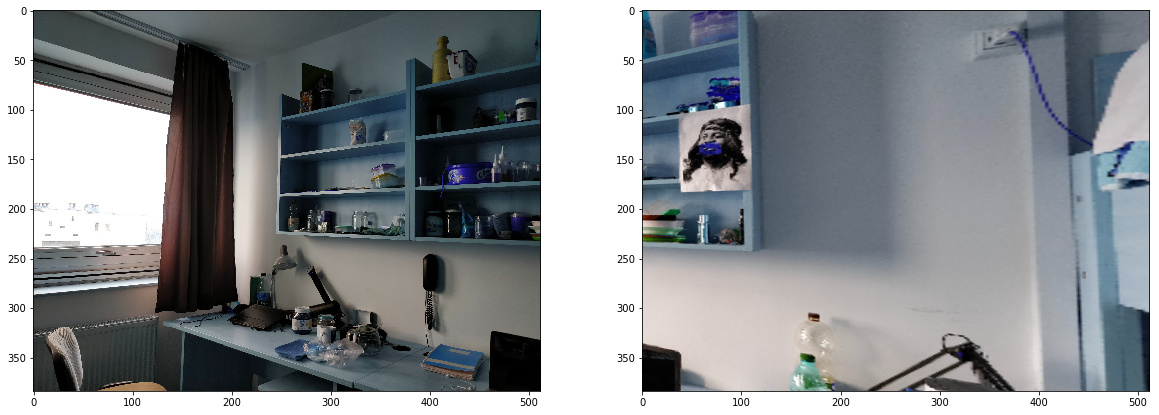

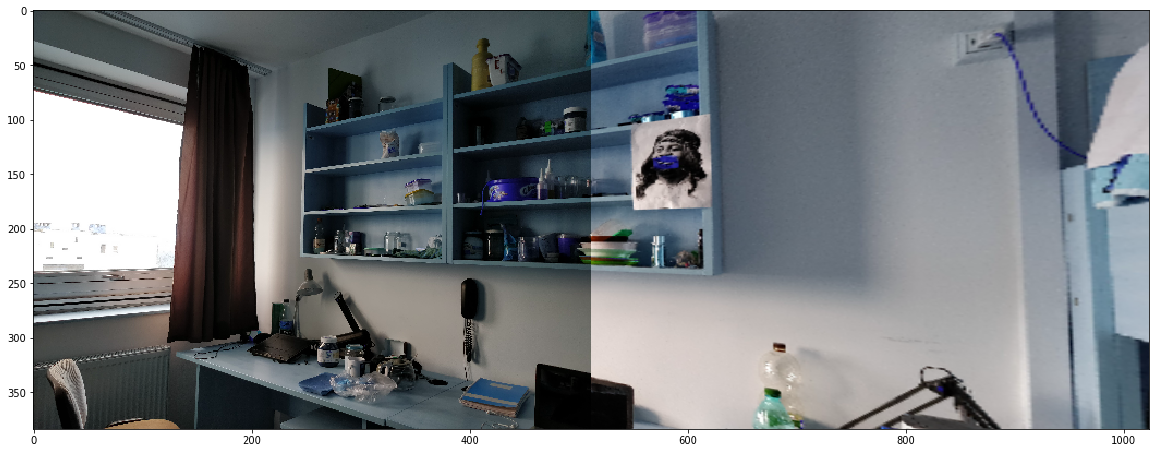

In [59]:
show_pics(2, 1, [A, B])
direct = np.concatenate([A, B], axis=1)
# show_pics(1, 1, [result])
show_pics(1, 1, [direct])

102
(384, 512, 3)


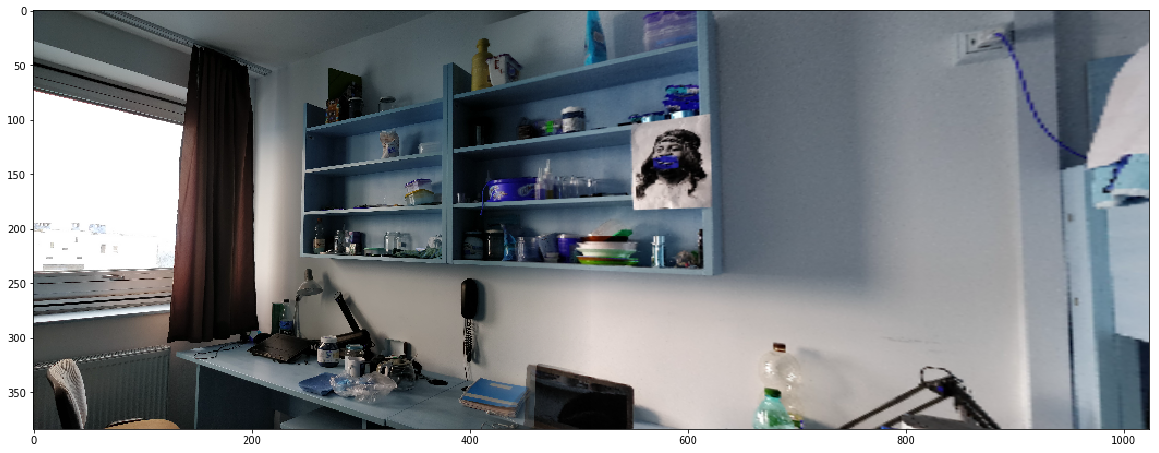

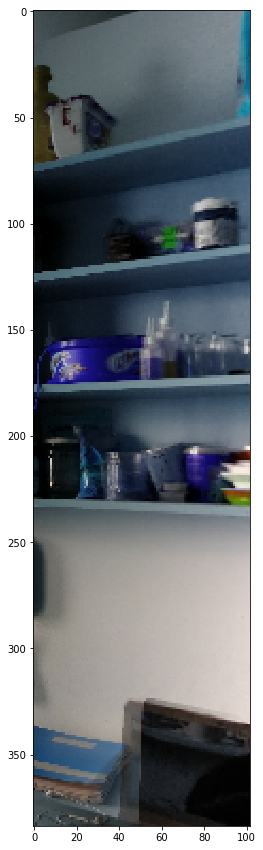

In [8]:
def frange(start, stop, n_steps):
    i = start
    step_c = 0
    step = (stop - start) / n_steps
    while (step_c < n_steps):#((step > 0) and (i < stop)) or ((step < 0) and (i > stop)):
        yield [i,i,i]
        i += step
        step_c += 1
        
overlapp = int(r_wr.shape[1]/10)
print(overlapp)
alpha_blend = r_wr.copy()
print(A.shape)
alpha_blend[:, A.shape[1]-overlapp:A.shape[1], :] = alpha_blend[:, A.shape[1]-overlapp:A.shape[1], :] * (
                                                                    np.array(list(frange(0, 1, overlapp))))
alpha_blend[:, :A.shape[1]-overlapp] = 0
tmp = A.copy()
tmp[:, -overlapp:] = tmp[:, -overlapp:]*np.array(list(frange(1, 0, overlapp)))
alpha_blend[:, :A.shape[1]] = alpha_blend[:, :A.shape[1]] + tmp
show_pics(1, 1, [alpha_blend])
show_pics(1, 1, [alpha_blend[:, A.shape[1]-overlapp:A.shape[1]]])

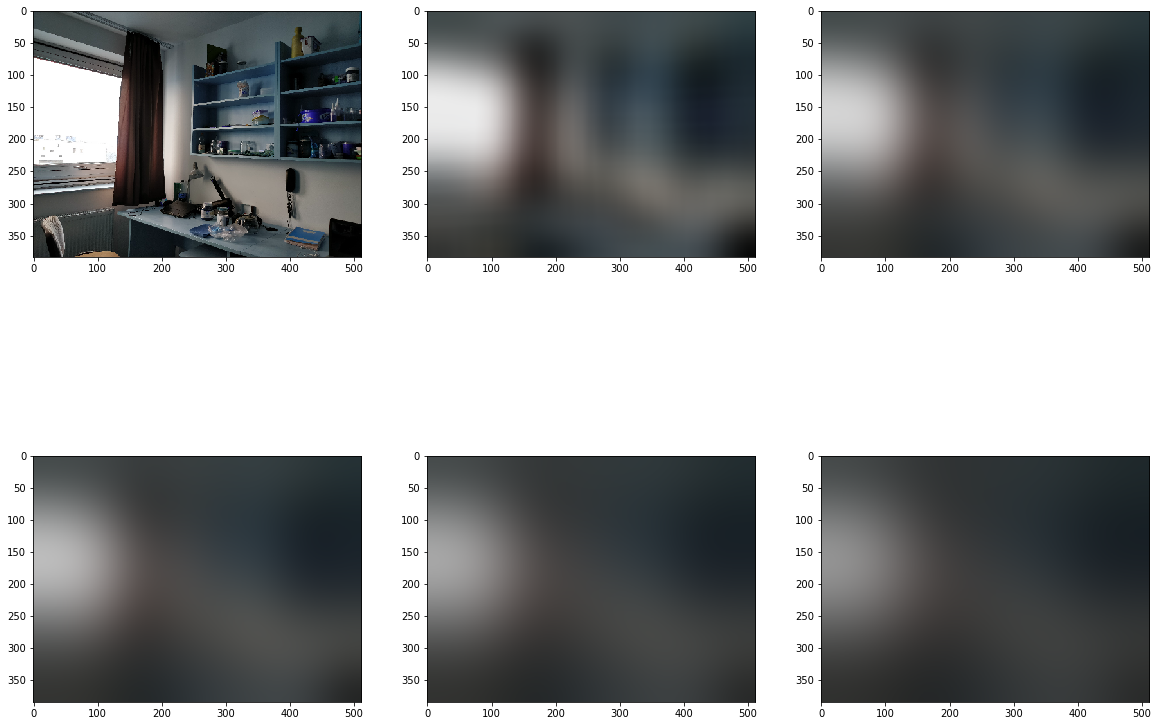

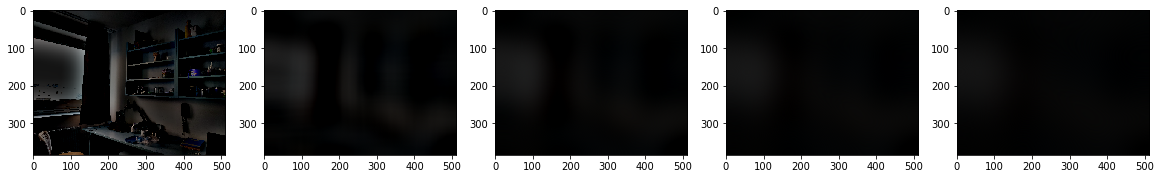

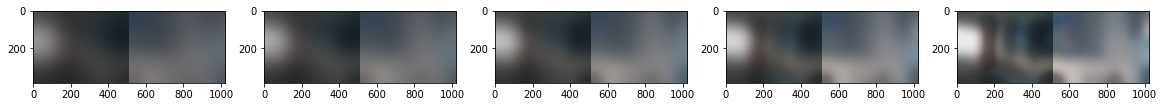

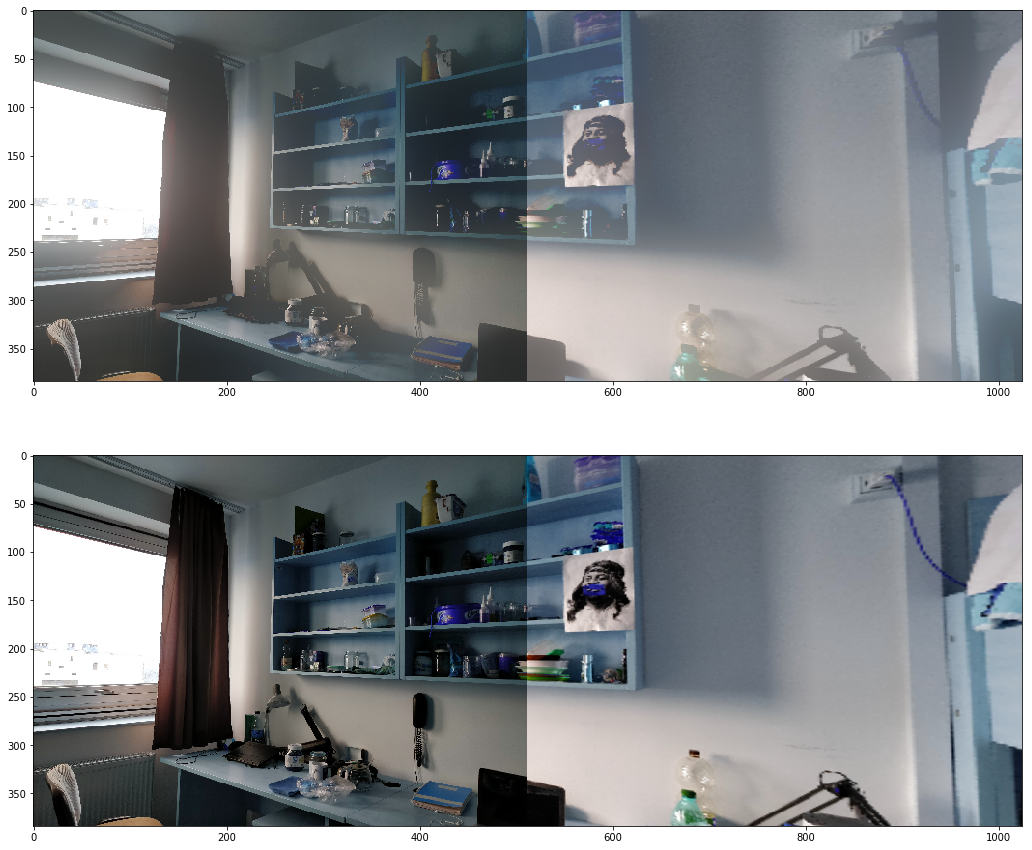

In [65]:
def generate_gaussian_pyramid(p, l, kernel_size):
    G = p.copy()
    gp = [G]
    for _ in range(l-1):
        # G = cv2.pyrDown(G)
        G = cv2.GaussianBlur(G, (kernel_size, kernel_size), 0)
        # G = G[0:-1:2, 0:-1:2]
        gp.append(G)
    return gp

def generate_laplacian_pyramid(gp, l):
    lp = []
    for i in range(l-1):
        L = cv2.subtract(gp[i],gp[i+1])
        lp.append(L)
    return lp


level = 6
row_n = 2
kernel_size = 191
gpA = generate_gaussian_pyramid(A, level, kernel_size)
gpB = generate_gaussian_pyramid(B, level, kernel_size)
show_pics(int(level/row_n), row_n, gpA)
lpA = generate_laplacian_pyramid(gpA, level)
lpB = generate_laplacian_pyramid(gpB, level)
show_pics(level-1, 1, lpA)
ls_ = [np.concatenate([gpA[-1], gpB[-1]], axis=1)] #LS[0]
for i in range(level-2, -1, -1):
    tmp = ls_[-1] # cv2.pyrUp(ls_[-1])
    tmp = cv2.add(tmp, np.concatenate([lpA[i], lpB[i]], axis=1))
    ls_.append(tmp)
show_pics(level-1, 1, ls_)
show_pics(1, 2, [ls_[-1], direct])

Feature detection and description generating.

Feature matching. Probably uses a multidimensional indexing structure (kd-tree, ect.) to find the 2 nearest neighbour to a description. If the 2 neares neighbour are simmular then the first one is probably correct, if not there was no match for the feature on the other image and the descriptions are very different.

The code uses RANSAC alg., to find a homogarphy. A homography maps 4 points to 4 other points. The RANSAC alg. selects random points, computes the homogarphy and determins the outlier ratio. Based on this ratio computes how many iteration is requred, so it will be highly probable there will be one sample wich has no outlier. Selects the homography with the most inliers.

Apply the homography to the image and bled the two seamlessly together.